In [1]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import random
sns.set()

In [16]:
""" Tricky experiments: 
- Gather all data from _data_ 
- Format data to be like (avg_degree, clustering, shortest path, powerlaw exp, r) -> (percent reduction in R)
- Use logistic regression to figure out best solution
"""

' Tricky experiments: \n- Gather all data from _data_ \n- Format data to be like (avg_degree, clustering, shortest path, powerlaw exp, r) -> (percent reduction in R)\n- Use logistic regression to figure out best solution\n'

In [7]:
def gather_data():
    data_file = open('../quarantine_by_props_1016A.pkl', 'rb')
    data = pickle.load(data_file)
    data_by_name = {}
    for datum in data:
        name = datum.get('name')
        if name not in data_by_name:
            data_by_name[name] = [] 
        data_by_name[name].append(datum)
    return data_by_name
data = gather_data()

In [8]:
# Part 0: Collect data by name and print all names...

def group_by_qprop(series):
    gather = {} 
    for datum in series:
        qprop = datum['quarantine_props']
        if qprop not in gather:
            gather[qprop] = [] 
        gather[qprop].append(datum)
        
    # and now modify to only collect final_R, max_I
    output = {}
    for qprop, datalist in gather.items():
        final_rs = [_['final_R'] for _ in datalist]
        max_is = [_['max_I'] for _ in datalist]
        output[qprop] = {'final_R': final_rs, 
                         'max_I': max_is}
    return output

def gather_by_name(data, name, i_or_r):
    # Gather triples of [(qprop, mean, std), ...]
    assert i_or_r in ['I', 'R']
    series = group_by_qprop(data[name])
    output = []
    def getter(doc):
        if i_or_r == 'I':
            return doc['max_I']
        else:
            return doc['final_R']
        
        
    for k, v in series.items():
        mean = np.mean(getter(v))
        std = np.std(getter(v))
        output.append((k, mean, std))
        
    return sorted(output, key=lambda trip: trip[0])
    

def size_lookup_by_name(name):
    if name in SYNTHETICS:
        return 10 ** 4 
    elif name.startswith('fb.'):
        return len(gg.load_gemsec_fb(name.split('.')[1]))
    elif name.startswith('deezer.'):
        return len(gg.load_gemsec_deezer(name.split('.')[1]))
    elif name.startswith('arxiv.'):
        return len(gg.load_arxiv_collab(name.split('.')[1]))
    elif name.startswith('hiv') or name.startswith('hs'):
        G = recreate_by_name(name)
        return len(G)
    
    
def recreate_by_name(name):
    # Don't worry too much about actual random seed, just gather parameters
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(name[2:]))
    elif name.startswith('plc'):
        m, p = name[3:].split('.')
        return gg.plc_graph(10 **4, int(m), float(p) / 100)
    elif name.startswith('rw'):
        assert name == 'rw.91.94'
        return gg.random_walk_graph(10 ** 4, 0.91, 0.94)
    elif name.startswith('nn'):
        assert name == 'nn.886'
        return gg.nearestNeighbor_mod(10 **4, 0.88,6)
    elif name.startswith('ws'):
        assert name == 'ws10.05'
        return gg.watts_strogatz_graph(10 ** 4, 10, 0.05)
    elif name.startswith('fb.'):
        return gg.load_gemsec_fb(name.split('.')[1])
    elif name.startswith('deezer.'):
        return gg.load_gemsec_deezer(name.split('.')[1])
    elif name.startswith('arxiv.'):
        return gg.load_arxiv_collab(name.split('.')[1])
    elif name.startswith('hs'):
        params = name[2:].split('_')
        return gg.load_highschool(float(params[0]), int(params[1]))
    elif name.startswith('hiv'):
        param = int(name[3:].split('R')[0])
        return gg.load_hiv(param)
    else:
        raise Exception("wut")
    return
    
    
def parse_data_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return recreate_by_name(name)
    params = name.split('_')
    R = params[-1]
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(params[1]))
    elif name.startswith('plc'):
        return gg.plc_graph(10 **4, int(params[1]), float(params[2]))
    elif name.startswith('rw'):
        return gg.random_walk_graph(10 ** 4, float(params[1]), float(params[2]))
    elif name.startswith('nn'):
        return gg.nearestNeighbor_mod(10 **4, float(params[1]),int(params[2]))
    elif name.startswith('ws'):
        return gg.watts_strogatz_graph(10 ** 4, int(params[1]), float(params[2]))

    
def get_r_by_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return 1
    params = name.split('_')
    return float(params[-1])



def get_minR_graph(data, name):
    # Gathers the graph (after minR optimal quarantine) 
    # 1) Get minR prop:
    minprop = min(gather_by_name(data, name, 'R'), key=lambda trip: trip[1])[0]
    
    
    # 2) Recreate graph and rerun 
    R = get_r_by_name(name)
    G = parse_data_name(name)
    outG = Q.run_until_prop_IR(G, R, 1, 10 / len(G), float('inf'), minprop)[0]
    return outG


#fig, ax = plt.subplots(figsize=(10,10)) #<---- general axis maker
def plot_vs(data, names, irs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    if not isinstance(names, list):
        names = [names]
    def plot_single_v(name, ir, ax=ax):
        try: 
            size = size_lookup[name]
        except:   
            size = 10 ** 4 # size_lookup[name]
        i_trips = gather_by_name(data, name, 'I')
        r_trips = gather_by_name(data, name, 'R')
        qprops = [_[0] for _ in i_trips]
        Is = [_[1] / size for _ in i_trips]
        qprops_r = [_[0] for _ in r_trips]
        Rs = [_[1] / size for _ in r_trips]
        if 'I' in ir:
            ax.plot(qprops, Is, label=name)
        if 'R' in ir:
            ax.plot(qprops, Rs, label=name)
    
    
    for name in names:
        plot_single_v(name, irs, ax=ax)
    ax.legend()
    

def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs

def return_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    return xform 



def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs


def get_powerlaw_exponent_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    #plt.scatter(*zip(*xform))
    slope, intercept, r_value, p_value, std_err = stats.linregress(*zip(*xform))
    return 1 -slope, r_value

        
def collect_graph_data_by_name(name, data=data):
    # Returns graph [name, nodes, average degree, cluster coefficient, powerlaw exponent, best_iTup, bestrTup] 
    G = recreate_by_name(name)
    nodes = len(G)
    avg_deg = sum(dict(G.degree()).values()) / len(G)
    cc = nx.average_clustering(G)
    powerlaw = get_powerlaw_exponent_cbin(G)
    no_q = gather_by_name(data, name, 'R')[0][1] /len(G)
    best_i = min(gather_by_name(data, name, 'I'), key=lambda tri: tri[1])
    best_i_prop = best_i[0]
    best_i_val = best_i[1] / nodes
    best_r = min(gather_by_name(data, name, 'R'), key=lambda tri: tri[1])
    best_r_prop = best_r[0]
    best_r_val = best_r[1] / nodes
    return [name, nodes, avg_deg, cc, powerlaw, no_q, best_r_prop, best_r_val]


def tabulate_by_name(names):
    headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'no_Q', 'best_r_prop', 'best_r_val']
    graph_data = [collect_graph_data_by_name(_) for _ in names]
    print(tabulate(graph_data, headers=headers, floatfmt='.2f'))
    return graph_data

In [19]:
# Want to do scatter plot over 'shortest path length' and 'reduction in quarantine' 
def avg_deg(G):
    return 2 * G.number_of_edges() / len(G)

def get_largest_cc(G):
    ccs = nx.connected_components(G)
    maxlen = 0
    max_ccset = None 
    for conn in ccs:
        if len(conn) > maxlen:
            maxlen = len(conn)
            max_ccset = conn
    return max_ccset


def avg_shortest_path(G, samples=10 * 1000):
    # Takes weighted average of connected component shortest paths? 
    # Randomly samples pairs of nodes in the largest connected component and computes average path length 
    ccset = get_largest_cc(G)
    sampleset = random.choices(list(ccset), k=samples * 2)
    len_sum = 0 
    count = 0
    for i in range(0, len(sampleset), 2):
        len_sum += nx.shortest_path_length(G, source=sampleset[i], target=sampleset[i+1])
        count += 1
    return len_sum / count
        
    
def get_change_summary(data, name):
    # Gets change of {cc, avg_deg, shortest path, powerlaw exponent}
    og_graph = parse_data_name(name)
    min_r_graph = get_minR_graph(data, name)
    
    og_cc = cluster(og_graph)
    og_avg = avg_deg(og_graph)
    og_sp = avg_shortest_path(og_graph)
    og_powerlaw = get_powerlaw_exponent_cbin(og_graph)
    
        
    cc = cluster(min_r_graph)
    avg = avg_deg(min_r_graph)
    sp = avg_shortest_path(min_r_graph)
    powerlaw = get_powerlaw_exponent_cbin(min_r_graph)
    
    return [name, og_cc, cc, og_avg, avg, og_sp, sp, og_powerlaw, powerlaw]

In [10]:

# Part 0: Collect data by name and print all names...

def gather_data():
    data_file = open('../quarantine_by_props_1016A.pkl', 'rb')
    data = pickle.load(data_file)
    data_by_name = {}
    for datum in data:
        name = datum.get('name')
        if name not in data_by_name:
            data_by_name[name] = [] 
        data_by_name[name].append(datum)
    return data_by_name

def group_by_qprop(series):
    gather = {} 
    for datum in series:
        qprop = datum['quarantine_props']
        if qprop not in gather:
            gather[qprop] = [] 
        gather[qprop].append(datum)
        
    # and now modify to only collect final_R, max_I
    output = {}
    for qprop, datalist in gather.items():
        final_rs = [_['final_R'] for _ in datalist]
        max_is = [_['max_I'] for _ in datalist]
        output[qprop] = {'final_R': final_rs, 
                         'max_I': max_is}
    return output

def gather_by_name(data, name, i_or_r):
    # Gather triples of [(qprop, mean, std), ...]
    assert i_or_r in ['I', 'R']
    series = group_by_qprop(data[name])
    output = []
    def getter(doc):
        if i_or_r == 'I':
            return doc['max_I']
        else:
            return doc['final_R']
        
        
    for k, v in series.items():
        mean = np.mean(getter(v))
        std = np.std(getter(v))
        output.append((k, mean, std))
        
    return sorted(output, key=lambda trip: trip[0])
    

def size_lookup_by_name(name):
    if name in SYNTHETICS:
        return 10 ** 4 
    elif name.startswith('fb.'):
        return len(gg.load_gemsec_fb(name.split('.')[1]))
    elif name.startswith('deezer.'):
        return len(gg.load_gemsec_deezer(name.split('.')[1]))
    elif name.startswith('arxiv.'):
        return len(gg.load_arxiv_collab(name.split('.')[1]))
    elif name.startswith('hiv') or name.startswith('hs'):
        G = recreate_by_name(name)
        return len(G)
    
    
def recreate_by_name(name):
    # Don't worry too much about actual random seed, just gather parameters
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(name[2:]))
    elif name.startswith('plc'):
        m, p = name[3:].split('.')
        return gg.plc_graph(10 **4, int(m), float(p) / 100)
    elif name.startswith('rw'):
        assert name == 'rw.91.94'
        return gg.random_walk_graph(10 ** 4, 0.91, 0.94)
    elif name.startswith('nn'):
        assert name == 'nn.886'
        return gg.nearestNeighbor_mod(10 **4, 0.88,6)
    elif name.startswith('ws'):
        assert name == 'ws10.05'
        return gg.watts_strogatz_graph(10 ** 4, 10, 0.05)
    elif name.startswith('fb.'):
        return gg.load_gemsec_fb(name.split('.')[1])
    elif name.startswith('deezer.'):
        return gg.load_gemsec_deezer(name.split('.')[1])
    elif name.startswith('arxiv.'):
        return gg.load_arxiv_collab(name.split('.')[1])
    elif name.startswith('hs'):
        params = name[2:].split('_')
        return gg.load_highschool(float(params[0]), int(params[1]))
    elif name.startswith('hiv'):
        param = int(name[3:].split('R')[0])
        return gg.load_hiv(param)
    else:
        raise Exception("wut")
    return
    
    
def parse_data_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return recreate_by_name(name)
    params = name.split('_')
    R = params[-1]
    if name.startswith('ba'):
        return gg.ba_graph(10 ** 4, int(params[1]))
    elif name.startswith('plc'):
        return gg.plc_graph(10 **4, int(params[1]), float(params[2]))
    elif name.startswith('rw'):
        return gg.random_walk_graph(10 ** 4, float(params[1]), float(params[2]))
    elif name.startswith('nn'):
        return gg.nearestNeighbor_mod(10 **4, float(params[1]),int(params[2]))
    elif name.startswith('ws'):
        return gg.watts_strogatz_graph(10 ** 4, int(params[1]), float(params[2]))

    
def get_r_by_name(name):
    prefixes = ['ba', 'plc', 'nn', 'rw', 'ws' ]
    match = None
    for prefix in prefixes:
        if name.startswith(prefix):
            match = prefix 
    if match is None or len(name.split('_')) == 1:
        return 1
    params = name.split('_')
    return float(params[-1])



def get_minR_graph(data, name):
    # Gathers the graph (after minR optimal quarantine) 
    # 1) Get minR prop:
    minprop = min(gather_by_name(data, name, 'R'), key=lambda trip: trip[1])[0]
    
    
    # 2) Recreate graph and rerun 
    R = get_r_by_name(name)
    G = parse_data_name(name)
    outG = Q.run_until_prop_IR(G, R, 1, 10 / len(G), float('inf'), minprop)[0]
    return outG


#fig, ax = plt.subplots(figsize=(10,10)) #<---- general axis maker
def plot_vs(data, names, irs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    if not isinstance(names, list):
        names = [names]
    def plot_single_v(name, ir, ax=ax):
        try: 
            size = size_lookup[name]
        except:   
            size = 10 ** 4 # size_lookup[name]
        i_trips = gather_by_name(data, name, 'I')
        r_trips = gather_by_name(data, name, 'R')
        qprops = [_[0] for _ in i_trips]
        Is = [_[1] / size for _ in i_trips]
        qprops_r = [_[0] for _ in r_trips]
        Rs = [_[1] / size for _ in r_trips]
        if 'I' in ir:
            ax.plot(qprops, Is, label=name)
        if 'R' in ir:
            ax.plot(qprops, Rs, label=name)
    
    
    for name in names:
        plot_single_v(name, irs, ax=ax)
    ax.legend()
    

def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs

def return_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    return xform 



def degree_hist(G):
    pairs = {}
    for _, d in G.degree():
        pairs[d] = pairs.get(d, 0) + 1
    return pairs


def get_powerlaw_exponent_cbin(G):
    # Returns best-fit powerlaw exponent by using cumulative binning 
    items = sorted(degree_hist(G).items(), key=lambda p:-p[0])
    cdf = []
    runsum = 0
    for deg, num in items:
        runsum += num 
        cdf.append((deg, runsum))
    xform = [(np.log(_[0]), np.log(_[1] / len(G))) for _ in cdf]
    #plt.scatter(*zip(*xform))
    slope, intercept, r_value, p_value, std_err = stats.linregress(*zip(*xform))
    return 1 -slope, r_value

        
def collect_graph_data_by_name(name, data=data):
    # Returns graph [name, nodes, average degree, cluster coefficient, powerlaw exponent, best_iTup, bestrTup] 
    G = recreate_by_name(name)
    nodes = len(G)
    avg_deg = sum(dict(G.degree()).values()) / len(G)
    cc = nx.average_clustering(G)
    powerlaw = get_powerlaw_exponent_cbin(G)
    no_q = gather_by_name(data, name, 'R')[0][1] /len(G)
    best_i = min(gather_by_name(data, name, 'I'), key=lambda tri: tri[1])
    best_i_prop = best_i[0]
    best_i_val = best_i[1] / nodes
    best_r = min(gather_by_name(data, name, 'R'), key=lambda tri: tri[1])
    best_r_prop = best_r[0]
    best_r_val = best_r[1] / nodes
    return [name, nodes, avg_deg, cc, powerlaw, no_q, best_r_prop, best_r_val]


def tabulate_by_name(names):
    headers=['name', 'nodes', 'avg_deg', 'cc', 'powerlaw', 'no_Q', 'best_r_prop', 'best_r_val']
    graph_data = [collect_graph_data_by_name(_) for _ in names]
    print(tabulate(graph_data, headers=headers, floatfmt='.2f'))
    return graph_data

print()

In [12]:
graphs = {}
for k in data.keys():
    print(k)
    graphs[k] = parse_data_name(k)

ba10
ba5
plc10.25
plc5.5
rw.91.94
nn.886
ws10.05
fb.artist
fb.athletes
fb.company
fb.new_sites
fb.government
deezer.RO
deezer.HR
deezer.HU
arxiv.AstroPh
arxiv.CondMat
arxiv.HepPh
arxiv.GrQc
arxiv.HepTh
hiv50R1
hiv50R3
hiv50R5
hs5_10
hs15_10
hs30_10
hs60_10
plc_5_0.5_0.03125
ba_5_0.25
ws_10_0.05_0.125
plc_5_0.5_0.25
ws_10_0.05_0.03125
plc_5_0.5_0.0625
ba_5_0.0625
ba_10_0.03125
ws_10_0.05_0.25
ba_5_0.03125
ws_10_0.05_2
rw_0.91_0.94_0.03125
ws_10_0.05_0.0625
rw_0.91_0.94_0.125
ba_5_0.125
ws_10_0.05_1
ws_10_0.05_0.5
plc_10_0.25_0.03125
ba_5_1
plc_5_0.5_0.125
rw_0.91_0.94_0.0625
ba_5_0.5
ws_10_0.05_4
ba_10_0.0625
plc_10_0.25_0.125
ws_10_0.05_8
ba_5_2
nn_0.88_6_0.03125
rw_0.91_0.94_0.25
ba_5_8
plc_5_0.5_2
ba_10_0.25
plc_5_0.5_0.5
ba_10_2
ba_5_4
plc_5_0.5_8
plc_5_0.5_1
ba_10_0.125
plc_10_0.25_0.0625
ba_10_4
plc_5_0.5_4
ba_10_0.5
ba_10_1
rw_0.91_0.94_8
rw_0.91_0.94_0.5
plc_10_0.25_4
plc_10_0.25_0.25
plc_10_0.25_0.5
rw_0.91_0.94_1
ba_10_8
rw_0.91_0.94_2
rw_0.91_0.94_4
plc_10_0.25_1
nn_0.88_6_0.

In [15]:
rs = {k: get_r_by_name(k) for k in data}

In [189]:
def get_struct_quad(G):
    # Gets the quadruple of (avg degree, shortest path, powerlaw_exp, cluster_coeff)
    ad = avg_deg(G)
    sp = avg_shortest_path(G) / len(G)
    powerlaw = get_powerlaw_exponent_cbin(G)[0]
    cc = nx.average_clustering(G)
    return (ad, sp, powerlaw, cc)

def get_quint_by_name(name):
    quad = get_struct_quad(graphs[name])
    rval = (rs[name],)
    return list(quad +rval)


def get_quarantine_percent(name, data=data):
    # Try percent change first
    nodes = len(graphs[name])
    no_q_r = gather_by_name(data, name,'R')[0][1]
    best_r = min(gather_by_name(data, name, 'R'), key=lambda tri: tri[1])[1]
    return (no_q_r - best_r) / nodes
    

In [41]:
graphs

{'ba10': <networkx.classes.graph.Graph at 0x7f5e90b138d0>,
 'ba5': <networkx.classes.graph.Graph at 0x7f5e852907f0>,
 'plc10.25': <networkx.classes.graph.Graph at 0x7f5e852909b0>,
 'plc5.5': <networkx.classes.graph.Graph at 0x7f5e852909e8>,
 'rw.91.94': <networkx.classes.graph.Graph at 0x7f5eba8ddb70>,
 'nn.886': <networkx.classes.graph.Graph at 0x7f5e85290978>,
 'ws10.05': <networkx.classes.graph.Graph at 0x7f5edfb73438>,
 'fb.artist': <networkx.classes.graph.Graph at 0x7f5ea2fdb2b0>,
 'fb.athletes': <networkx.classes.graph.Graph at 0x7f5edfd12898>,
 'fb.company': <networkx.classes.graph.Graph at 0x7f5e6047f2b0>,
 'fb.new_sites': <networkx.classes.graph.Graph at 0x7f5e5ec587f0>,
 'fb.government': <networkx.classes.graph.Graph at 0x7f5e599a3be0>,
 'deezer.RO': <networkx.classes.graph.Graph at 0x7f5e57876a90>,
 'deezer.HR': <networkx.classes.graph.Graph at 0x7f5e53965278>,
 'deezer.HU': <networkx.classes.graph.Graph at 0x7f5e474c02b0>,
 'arxiv.AstroPh': <networkx.classes.graph.Graph at 

In [53]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
sorted_keys = sorted(data.keys())
X = []
for k in sorted_keys:
    print(k)
    X.append(get_quint_by_name(k))

arxiv.AstroPh
arxiv.CondMat
arxiv.GrQc
arxiv.HepPh
arxiv.HepTh
ba10
ba5
ba_10_0.03125
ba_10_0.0625
ba_10_0.125
ba_10_0.25
ba_10_0.5
ba_10_1
ba_10_2
ba_10_4
ba_10_8
ba_5_0.03125
ba_5_0.0625
ba_5_0.125
ba_5_0.25
ba_5_0.5
ba_5_1
ba_5_2
ba_5_4
ba_5_8
deezer.HR
deezer.HU
deezer.RO
fb.artist
fb.athletes
fb.company
fb.government
fb.new_sites
hiv50R1
hiv50R3
hiv50R5
hs15_10
hs30_10
hs5_10
hs60_10
nn.886
nn_0.88_6_0.03125
nn_0.88_6_0.0625
nn_0.88_6_0.125
nn_0.88_6_0.25
nn_0.88_6_0.5
nn_0.88_6_1
nn_0.88_6_2
nn_0.88_6_4
nn_0.88_6_8
plc10.25
plc5.5
plc_10_0.25_0.03125
plc_10_0.25_0.0625
plc_10_0.25_0.125
plc_10_0.25_0.25
plc_10_0.25_0.5
plc_10_0.25_1
plc_10_0.25_2
plc_10_0.25_4
plc_10_0.25_8
plc_5_0.5_0.03125
plc_5_0.5_0.0625
plc_5_0.5_0.125
plc_5_0.5_0.25
plc_5_0.5_0.5
plc_5_0.5_1
plc_5_0.5_2
plc_5_0.5_4
plc_5_0.5_8
rw.91.94
rw_0.91_0.94_0.03125
rw_0.91_0.94_0.0625
rw_0.91_0.94_0.125
rw_0.91_0.94_0.25
rw_0.91_0.94_0.5
rw_0.91_0.94_1
rw_0.91_0.94_2
rw_0.91_0.94_4
rw_0.91_0.94_8
ws10.05
ws_10_0.05_

In [54]:
Y = [get_quarantine_percent(k) for k in sorted_keys]

In [56]:
reg = linear_model.LinearRegression()
reg.fit(X, Y)

LinearRegression()

In [77]:
def plot_by_feature(idx, x,y):
    plt.scatter([_[idx] for _ in x], y)

In [74]:
sort_by_r = {}
for i in range(len(X)):
    r = X[i][-1]
    if r not in sort_by_r:
        sort_by_r[r] = [[],[]] 
    sort_by_r[r][0].append(X[i])
    sort_by_r[r][1].append(Y[i])
    

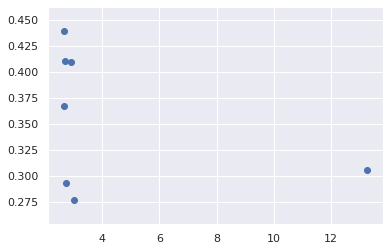

In [81]:
plot_by_feature(2, *sort_by_r[0.5])

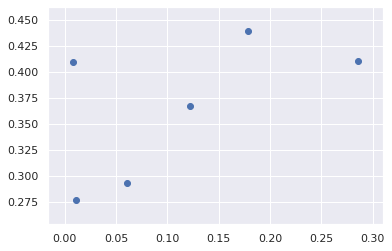

In [94]:
plot_by_feature(3, sort_by_r[0.5][0][:-1], sort_by_r[0.5][1][:-1])

In [101]:
x5, y5 = sort_by_r[0.5][0][:-1], sort_by_r[0.5][1][:-1]
testreg = linear_model.LinearRegression()
testreg.fit(x5, y5)
r2_score(testreg.predict(x5), y5)

0.9997422618690156

In [108]:
def get_r2_by_r(r):
    xx, yy = sort_by_r[r][0][:-1], sort_by_r[r][1][:-1]
    testreg = linear_model.LinearRegression()
    testreg.fit(xx, yy)
    return testreg.coef_, r2_score(testreg.predict(xx), yy)

In [109]:
for testr in [0.125, 0.25, 0.5, 2]:
    print("R", testr, get_r2_by_r(testr))

R 0.125 (array([-0.00930344,  0.05294839, -0.16855291, -0.10855449,  0.        ]), 0.9977165129963492)
R 0.25 (array([-0.00538347,  0.11301524, -0.08923925,  0.06505435,  0.        ]), 0.9993023772092156)
R 0.5 (array([-0.00298461,  0.16543747, -0.11267253,  0.12100397,  0.        ]), 0.9997422618690156)
R 2 (array([ 0.00284545,  0.20137336, -0.00853718,  0.44981381,  0.        ]), 0.9975402446220616)


In [114]:
Xreal = []
Yreal = []
for k in sorted_keys:
    if not( k.startswith('arxiv') or k.startswith('deezer') or k.startswith('fb')):
        continue
    print(k)
    
    Xreal.append(get_quint_by_name(k))
    Yreal.append(get_quarantine_percent(k))

arxiv.AstroPh
arxiv.CondMat
arxiv.GrQc
arxiv.HepPh
arxiv.HepTh
deezer.HR
deezer.HU
deezer.RO
fb.artist
fb.athletes
fb.company
fb.government
fb.new_sites


In [153]:
realreg = linear_model.LinearRegression()
realreg.fit(Aprime, Yreal)
realpred = realreg.predict(Aprime)
print(r2_score(realpred, Yreal))

0.7580070211111211


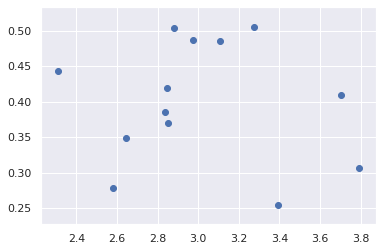

In [181]:
plot_by_feature(2, Xreal, Yreal)

In [135]:
# Center: 
A = np.array([list(_[:-1]) for _ in Xreal])
Aprime = (A - A.mean(axis=0)) / A.std(axis=0)


In [161]:
Xreal

[(21.10696782441935, 4.187, 2.8341885079219566, 0.6305932411707943, 1),
 (8.083430596982666, 5.363, 3.105684718276472, 0.6334130270820665, 1),
 (5.530713468141931, 6.0572, 2.8810900986395005, 0.529635811052136, 1),
 (19.740339773484344, 4.6599, 2.3100988004575402, 0.6114825236824339, 1),
 (5.264351523742027, 5.9454, 3.276478575985644, 0.4714390529669332, 1),
 (18.257553825011453, 4.4985, 3.3908677535409915, 0.13647174362435588, 1),
 (9.376861590239798, 5.3347, 3.7911015748095784, 0.11618233863493775, 1),
 (6.024033512866547, 6.3441, 3.7033138691444494, 0.09120797046991468, 1),
 (32.4368826335689, 3.6902, 2.643106686438551, 0.13811495287065234, 1),
 (12.526535910008652, 4.2723, 2.8476187754078945, 0.27614853940273026, 1),
 (7.41211477151966, 5.2941, 2.9738746289840985, 0.2392079390902055, 1),
 (25.34523303584077, 3.779, 2.579581857183071, 0.41076781193737977, 1),
 (14.775600845302483, 4.3984, 2.850199750093277, 0.2953695976286596, 1)]

In [169]:
REALS = [_ for _ in data.keys() if _.startswith('arxiv') or _.startswith('fb') or _.startswith('deezer')]
quads_by_name = {k: get_struct_quad(graphs[k]) for k in REALS}

In [188]:
print(tabulate([(k,) + v + (get_quarantine_percent(k),) for k,v in quads_by_name.items()], floatfmt='0.5f'))

-------------  --------  -------  -------  -------  -------
fb.artist      32.43688  0.00007  2.64311  0.13811  0.34917
fb.athletes    12.52654  0.00031  2.84762  0.27615  0.41942
fb.company      7.41211  0.00038  2.97387  0.23921  0.48726
fb.new_sites   14.77560  0.00016  2.85020  0.29537  0.36933
fb.government  25.34523  0.00053  2.57958  0.41077  0.27813
deezer.RO       6.02403  0.00015  3.70331  0.09121  0.40965
deezer.HR      18.25755  0.00008  3.39087  0.13647  0.25498
deezer.HU       9.37686  0.00011  3.79110  0.11618  0.30677
arxiv.AstroPh  21.10697  0.00022  2.83419  0.63059  0.38527
arxiv.CondMat   8.08343  0.00023  3.10568  0.63341  0.48518
arxiv.HepPh    19.74034  0.00039  2.31010  0.61148  0.44326
arxiv.GrQc      5.53071  0.00116  2.88109  0.52964  0.50303
arxiv.HepTh     5.26435  0.00060  3.27648  0.47144  0.50563
-------------  --------  -------  -------  -------  -------


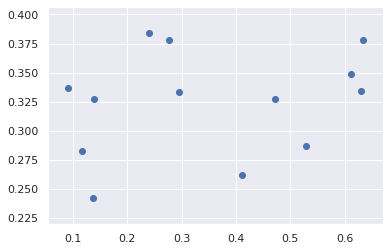

In [192]:
realx = [quads_by_name[_] for _ in REALS]
realy = [get_quarantine_percent(_) for _ in REALS]
scaled = [_[3] for _ in realx]
plt.scatter(scaled, realy)

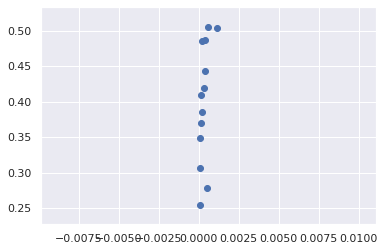

In [184]:
plot_by_feature(1, realpx, realy)

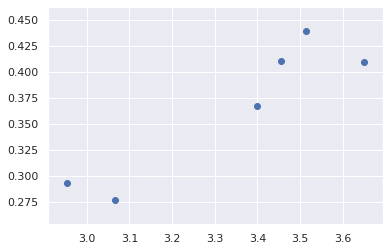

In [202]:
################
plot_by_feature(1, sort_by_r[0.5][0][:-1], sort_by_r[0.5][1][:-1] )

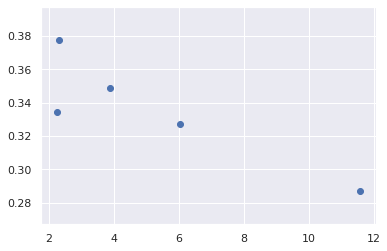

In [220]:
plt.scatter([_[1] * 1e4 for _ in realx[-5:]], realy[-5:])

In [ ]:
plt.scatter([_[1] * 1e3 for _ in realx[-5:]], realy[-5:])